# Import Libraries

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load Weights

In [2]:
# taken from github
# We load the WEIGHTS into our tensorflow model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Defining Arguments

In [3]:
inWidth = 368      # Resize input to a specific width
inHeight = 368     # Resize input to a specific height
thr = 0.2          # threshold value for pose parts heat map

# Define Body Parts and Create Pairs

In [4]:
# define body parts
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

# to form connections between body parts to create a skeleton
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("Person.jpg")

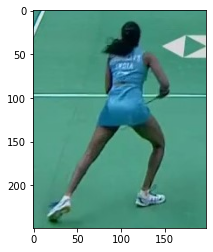

In [6]:
# convert bgr format into rgb
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# Pose Estimation of an Image

In [9]:
def pose_estimation(frame):
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # load image and pass it through neural networks model
    # (image, scalefactor, size, mean, convert BGR into RGB)
    # mean: to normalize pixel values: subtract 255/2 from each RGB channel
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    
    # Runs a forward pass to compute the net output
    # gives a Numpy array as the output
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    # checks whether the condition True
    # If not, then AssertionError
    assert(len(BODY_PARTS) == out.shape[1])

    # To add positions of body parts if it's confidence from heatMap > threshold
    points = []
    
    # Generate heatMap for each keypoint
    for i in range(len(BODY_PARTS)):
        
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]
        
        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at a time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
    
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
       
        
    # To join/connect all the positions of the body parts and display it
    for pair in POSE_PAIRS:
        
        partFrom = pair[0]
        partTo = pair[1]
        
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.putText(frame, str(idFrom), points[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
            cv.putText(frame, str(idTo), points[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
    
    return frame, points

In [10]:
img = cv.imread("Person.jpg")
estimated_image, estimated_points = pose_estimation(img)

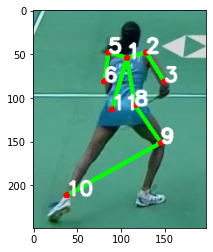

In [11]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [12]:
estimated_points

[None,
 (107, 54),
 (129, 48),
 (150, 81),
 None,
 (86, 48),
 (81, 81),
 None,
 (116, 108),
 (146, 151),
 (38, 211),
 (90, 113),
 None,
 (124, 205),
 None,
 None,
 (116, 32),
 (99, 32),
 (189, 86)]

# Pose Estimation in a Video

In [13]:
def pose_estimation_video(video):

    cap = cv.VideoCapture(video)

    while cv.waitKey(1) < 0:
        success, frame = cap.read()
        if not success:
            cv.waitKey()
            break

        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]

        # load image and pass it through neural networks model
        # (image, scalefactor, size, mean, convert BGR into RGB)
        # mean: to normalize pixel values: subtract 255/2 from each RGB channel
        net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))

        # Runs a forward pass to compute the net output
        # gives a Numpy array as the output
        out = net.forward()
        out = out[:, :14, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 14 elements

        # checks whether the condition True
        # If not, then AssertionError
        assert(len(BODY_PARTS) == out.shape[1])

        # To add positions of body parts if it's confidence from heatMap > threshold
        points = {}

        # Generate heatMap for each keypoint
        for i, body_part in enumerate(BODY_PARTS.keys()):

            # Slice heatmap of corresponding body's part.
            heatMap = out[0, i, :, :]

            # Originally, we try to find all the local maximums. To simplify a sample
            # we just find a global one. However only a single pose at a time
            # could be detected this way.
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]

            if body_part == 'Head':
                head_pos = ((int(x), int(y)) if conf > thr else None)
        
            else:
                # Add a point if it's confidence is higher than threshold.
                points[body_part] = ((int(x), int(y)) if conf > thr else None)

        # To join/connect all the positions of the body parts and display it
        for pair in POSE_PAIRS:

            if 'Head' in pair:
                continue

            else: 
                assert(pair[0] in BODY_PARTS)
                assert(pair[1] in BODY_PARTS)

                idFrom = BODY_PARTS[pair[0]]
                idTo = BODY_PARTS[pair[1]]

                if points[pair[0]] and points[pair[1]]:
                    cv.line(frame, points[pair[0]], points[pair[1]], (0, 255, 0), 3)
                    cv.ellipse(frame, points[pair[0]], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                    cv.ellipse(frame, points[pair[1]], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                    cv.putText(frame, str(idFrom), points[pair[0]], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
                    cv.putText(frame, str(idTo), points[pair[1]], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)

        cv.imshow('Pose Extimation', frame)
        
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    return points, head_pos

In [14]:
points = pose_estimation_video('match1.mp4')

In [14]:
points

[None,
 (556, 360),
 (556, 360),
 (584, 375),
 (584, 391),
 (556, 360),
 (528, 375),
 (528, 406),
 (556, 406),
 (556, 422),
 (556, 469),
 (556, 406),
 (528, 438),
 (556, 469),
 None,
 None,
 (556, 344),
 (556, 344),
 (1252, 673)]

# Relative Pose Estimation of an Image

In [19]:
def pose_estimation(frame):
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # load image and pass it through neural networks model
    # (image, scalefactor, size, mean, convert BGR into RGB)
    # mean: to normalize pixel values: subtract 255/2 from each RGB channel
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    
    # Runs a forward pass to compute the net output
    # gives a Numpy array as the output
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    # checks whether the condition True
    # If not, then AssertionError
    assert(len(BODY_PARTS) == out.shape[1])

    # To add positions of body parts if it's confidence from heatMap > threshold
    points = []
    relative_pos = []
    
    # Generate heatMap for each keypoint
    for i in range(len(BODY_PARTS)):
        
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]
        
        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at a time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
    
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
       
        for i in range(len(points)):
            if points[i] is not None and points[1] is not None:
                x = points[i][0] - points[1][0] 
                y = points[i][1] - points[1][1]  
                relative_pos.append((x,y))
            else:
                relative_pos.append(points[i])
        
    # To join/connect all the positions of the body parts and display it
    for pair in POSE_PAIRS:
        
        assert(pair[0] in BODY_PARTS)
        assert(pair[1] in BODY_PARTS)

        idFrom = BODY_PARTS[pair[0]]
        idTo = BODY_PARTS[pair[1]]

        if relative_pos[idFrom] and relative_pos[idTo]:
            cv.line(frame, relative_pos[idFrom], relative_pos[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, relative_pos[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, relative_pos[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.putText(frame, str(idFrom), relative_pos[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
            cv.putText(frame, str(idTo), relative_pos[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
    
    return frame, points, relative_pos

In [20]:
img = cv.imread("Person.jpg")
estimated_image, estimated_points, relative_position = pose_estimation(img)

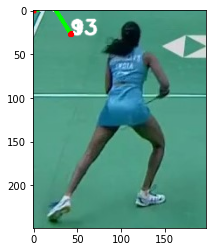

In [21]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [23]:
estimated_points

[None,
 (107, 54),
 (129, 48),
 (150, 81),
 None,
 (86, 48),
 (81, 81),
 None,
 (116, 108),
 (146, 151),
 (38, 211),
 (90, 113),
 None,
 (124, 205),
 None,
 None,
 (116, 32),
 (99, 32),
 (189, 86)]

In [25]:
relative_position

[None,
 None,
 (0, 0),
 None,
 (0, 0),
 (22, -6),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 (39, 97),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 (39, 97),
 (-69, 157),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 (39, 97),
 (-69, 157),
 (-17, 59),
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 (39, 97),
 (-69, 157),
 (-17, 59),
 None,
 None,
 (0, 0),
 (22, -6),
 (43, 27),
 None,
 (-21, -6),
 (-26, 27),
 None,
 (9, 54),
 (39, 97),
 (-69, 157),
 (-17, 59),